In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

Matplotlib is building the font cache; this may take a moment.


In [22]:
import cmocean

In [31]:
rds = xr.open_zarr("/p1-evaluation/v1/validation/replay.geopotential.20.zarr/")
rds

<xarray.Dataset> Size: 7MB
Dimensions:       (level: 3, time: 20, latitude: 119, longitude: 240)
Coordinates:
  * latitude      (latitude) float64 952B -88.5 -87.0 -85.5 ... 85.5 87.0 88.5
  * level         (level) int64 24B 100 500 850
  * longitude     (longitude) float64 2kB 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * time          (time) datetime64[ns] 160B 1994-07-19T12:00:00 ... 2022-10-...
Data variables:
    geopotential  (level, time, latitude, longitude) float32 7MB dask.array<chunksize=(2, 10, 60, 120), meta=np.ndarray>
Attributes:
    regrid_method:  conservative

In [32]:
rds = rds.where(rds.time.dt.hour / 6 == rds.time.dt.hour//6, drop=True)

In [33]:
era = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr",
    storage_options={"anon": True},
)
era = era.sel(
    time=rds.time,
    level=rds.level,
)

In [34]:
rds.geopotential.load()
era.geopotential.load();

In [36]:
diff = rds - era
adiff = np.abs(rds-era)
rdiff = adiff / np.abs(era)

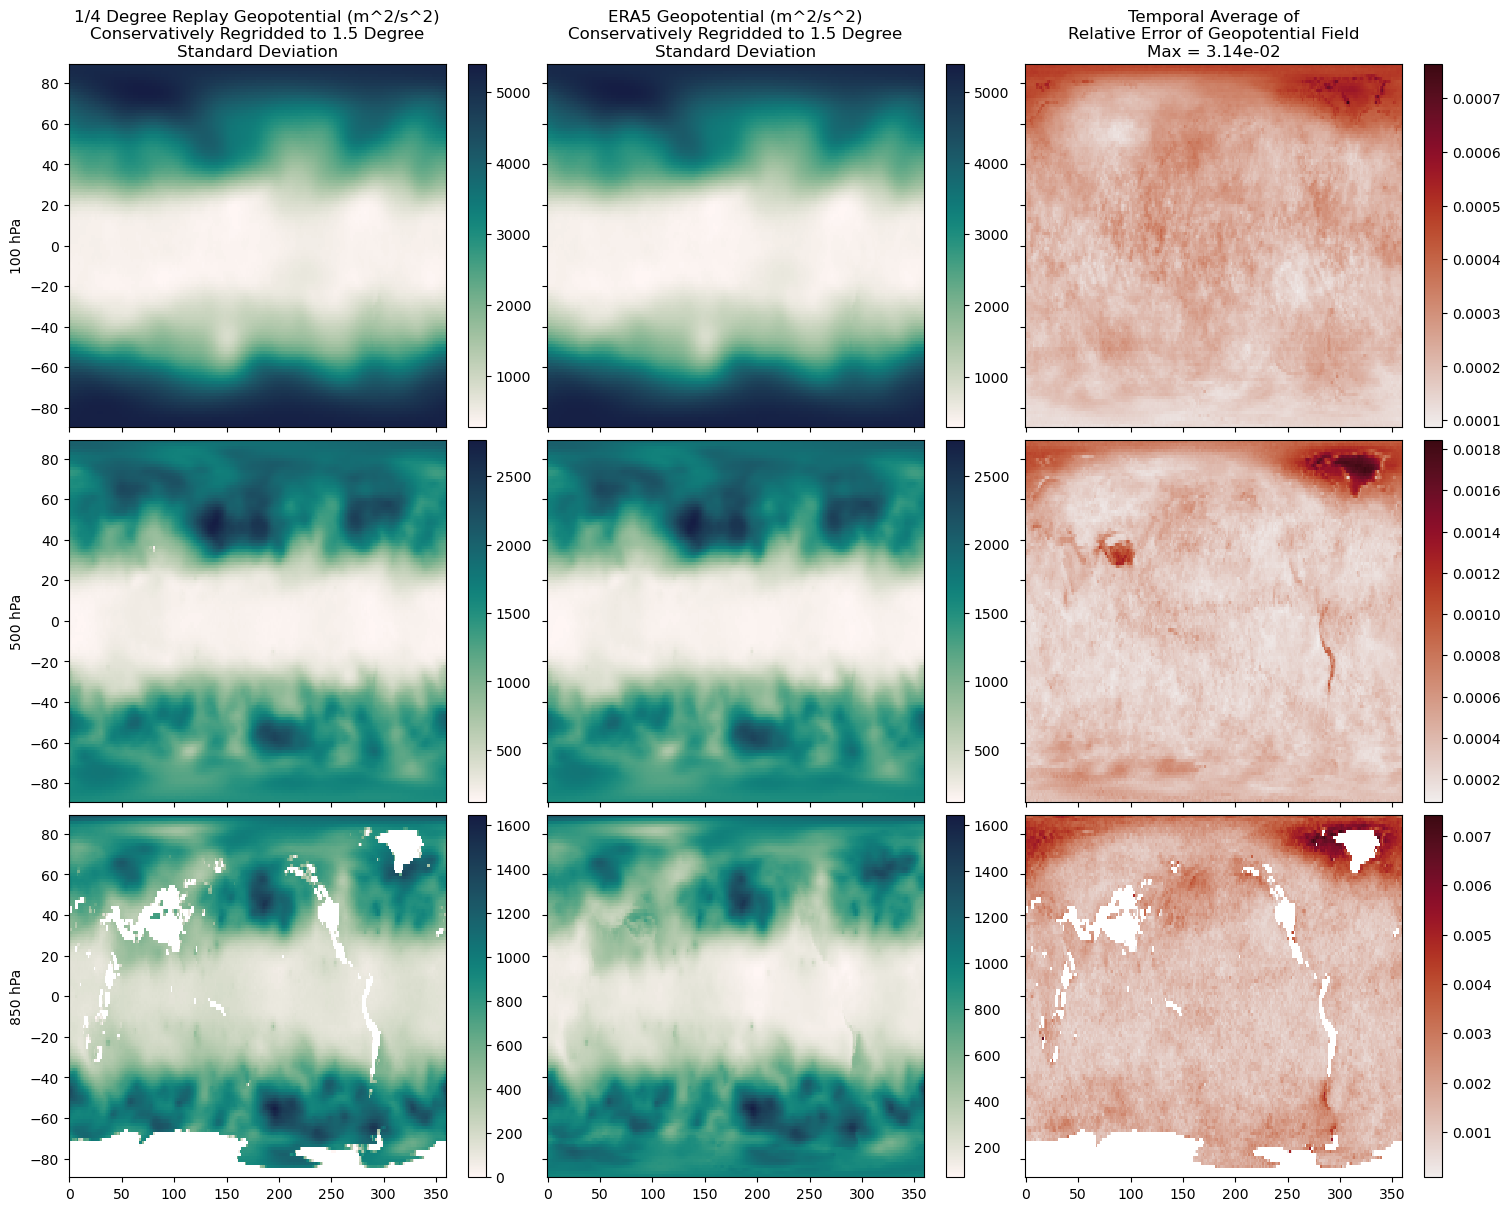

In [39]:
fig, axs = plt.subplots(3, 3, figsize=(15,12), constrained_layout=True, sharex=True, sharey=True)

itime = 0

for level, axr in zip([100, 500, 850], axs):
    for xds, name, reduction, ax in zip(
        [rds, era, rdiff,rdiff],
        ["1/4 Degree Replay Geopotential (m^2/s^2)\nConservatively Regridded to 1.5 Degree\nStandard Deviation",
         "ERA5 Geopotential (m^2/s^2)\nConservatively Regridded to 1.5 Degree\nStandard Deviation",
         "Temporal Average of\nRelative Error of Geopotential Field",
        ],
        ["std", "std", "mean"],
        axr):
        plotme = xds["geopotential"].sel(level=level)
        if reduction == "std":
            plotme = plotme.std("time")
            cmap = "cmo.tempo"
        elif reduction == "mean":
            plotme = plotme.mean("time")
            cmap = "cmo.amp"
        elif reduction == "max":
            plotme = plotme.max("time")
            cmap = "cmo.amp"
            
        else:
            raise NotImplementedError
        plotme.plot(ax=ax, x="longitude", cbar_kwargs={"label":""}, cmap=cmap)

        sps = ax.get_subplotspec()
        if "Relative Error" in name:
            name += f"\nMax = {xds.geopotential.max().values:1.2e}"
        ax.set(
            ylabel=f"{level} hPa" if sps.is_first_col() else "",
            xlabel="",
            title=name if sps.is_first_row() else "",
        )
fig.savefig(f"figures/verify_replay_geopotential.jpeg", dpi=300, bbox_inches="tight")